# Exploratory Data Analysis - MIMIC-IV Dataset in PostgreSQL

The notebook has been implemented using Python 3.10.11.  
The MIMIC-IV v2.2 dataset has been loaded into PostgreSQL server running PostgreSQL 15.2 (Ubuntu 15.2-1.pgdg22.04+1).  
We suggest creating a virtual environment for this notebook.  
You need to install the following packages to run this notebook:

| Package Name | License                                                                                                                 | Documentation                           |
|--------------|-------------------------------------------------------------------------------------------------------------------------|-----------------------------------------|
| psycopg2     | [![License: LGPL v3](https://img.shields.io/badge/License-LGPL_v3-blue.svg)](https://www.gnu.org/licenses/lgpl-3.0)     | [Docs](https://www.psycopg.org/)        |
| pandas       | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://pandas.pydata.org/)      |
| numpy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://numpy.org/)              |
| seaborn      | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://seaborn.pydata.org/)     |
| scipy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://scipy.org/)              |
| tomli        | [![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT)               | [Docs](https://github.com/hukkin/tomli) |
| tqdm         | [![License](https://img.shields.io/pypi/l/tqdm.svg)](https://github.com/tqdm/tqdm/blob/master/LICENCE)                  | [Docs](https://tqdm.github.io/)         |
| matplotlib   | [(BSD-compatible, PSF-based)](https://matplotlib.org/stable/users/project/license.html)                                 | [Docs](https://matplotlib.org/)         |


In [1]:
"""Update pip and install requirements."""
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
"""Relevant imports for EDA; setup and styling."""

# data manipulation
import numpy as np
import pandas as pd

# data vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# tqdm for progress bars
from tqdm import tqdm

# default styling for plots
plt.style.use("ggplot")  # gnuplot style
rcParams["figure.figsize"] = 12, 6  # figure size
from matplotlib.colors import ListedColormap

# hls colormap for sns styled pie charts using matplotlib
hls = ListedColormap(sns.color_palette("hls").as_hex())

In [2]:
"""Functions for database connection, query execution, dataframe plotting."""

import tomli as toml
import psycopg2 as pg
from typing import Any


def read_config(path: str) -> dict:
    """Read config file and return config dict."""
    with open(path, "rb") as f:
        config = toml.load(f)["database"]
    return config


def connect_to_db(config: dict) -> Any:
    """Connect to database and return connection object."""
    conn = pg.connect(**config)
    cur = conn.cursor()
    return conn, cur


def read_sql(path: str) -> str:
    """Read SQL file and returns string"""
    with open(path, "r") as f:
        sql = f.read()
    return sql


def sql_to_df(path: str, params: dict = None) -> pd.DataFrame:
    """Read SQL file, execute query and return pandas DataFrame.

    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    conn.close()
    return df


def exec_sql(path: str, params: dict = None):
    """Read SQL file, execute query and return pandas DataFrame.

    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    conn.close()


def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    title: str = "",
    figsize=(10, 5),
    linewidth=0.3,
    fmt=".2f",
    annot_kws={"size": 10},
    cmap="Spectral_r",
    cbar=True,
    ax=None,
    cbar_kws={"shrink": 0.8},
) -> None:
    """Plot heatmap of correlation matrix."""
    # set figure size
    if ax is None:
        plt.subplots(figsize=figsize)
    corr = df.corr(method)
    sns.heatmap(
        corr,
        cbar=cbar,  # show color bar? yes/no
        annot=True,  # show numbers in cells? yes/no
        square=True,  # square cells? yes/no
        linewidths=linewidth,  # linewidth between cells
        fmt=fmt,  # precision
        annot_kws=annot_kws,  # size of numbers in cells
        yticklabels=df.columns,  # y-axis labels
        xticklabels=df.columns,  # x-axis labels
        cmap=cmap,  # color palette
        ax=ax,  # axes object
        cbar_kws=cbar_kws,  # shrink color bar
    )
    if title:
        plt.title(title)
    if ax is None:
        plt.show()


def plot_boxplot_grid(df: pd.DataFrame, target: str) -> None:
    """Plot boxplots of multiple columns against a single target variable."""
    # calculate number of rows and columns
    n_cols = int(np.ceil(np.sqrt(len(df.columns) - 1)))
    n_rows = int(np.ceil((len(df.columns) - 1) / n_cols))
    # create figure and axes
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5)
    )
    # iterate over columns, rows and create boxplots
    for col, ax in zip(df.columns.drop(target), axes.flatten()):
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        # set title to column name vs. target
        ax.set_title(f"{col} vs. {target}")
    plt.show()


def plot_corr_matrix_diff(
    df_one: pd.DataFrame,
    df_two: pd.DataFrame,
    method: str = "pearson",
    figsize=(10, 5),
    cmap="vlag",
    title="",
    ax=None,
) -> None:
    """Plot heatmap of difference of correlation matrices."""
    # calculate difference of correlation matrices
    corr_diff = df_one.corr(method) - df_two.corr(method)
    # plot heatmap
    plt.subplots(figsize=figsize)
    # draw arrows in cells according to correlation difference?
    sns.heatmap(
        corr_diff,
        annot=True,
        annot_kws={"size": 10},
        cbar=True,
        cmap=cmap,
        fmt=".2f",
        square=True,
        center=0,
        ax=ax,
    )
    plt.title(title)
    if ax is None:
        plt.show()


def plot_pie_chart(df, col="race", title="", ax=None, cmap=hls, explode=0.1):
    """Plot pie chart for a given column in a dataframe."""
    explode = [explode] * len(df[col].value_counts())
    df[col].value_counts().plot.pie(
        shadow=True,
        autopct="%1.1f%%",
        startangle=90,
        title=title,
        cmap=cmap,
        ax=ax,
        labeldistance=1.1,
        pctdistance=0.5,
        explode=explode,
    )
    if ax is None:
        plt.show()

### Cohort Selection & Feature Engineering

In [4]:
# Constants
WINDOW_SIZE_H = 8  # Feature window should start 8 hours before the event
WINDOW_STOP_SIZE_H = 2  # Feature window should stop 2 hours before the event
RANDOM_SEED = 42  # Random state for reproducibility

In [22]:
# Prepare the database. 
# These sql files is used in our cohort selection and creates the table containing (real and matched) sepsis onset times for all patients within our cohort.
# The cohort selection MUST be executed first, as the sepsis table query depends on it.

# 1. Cohort selection
# exec_sql("./sql/cohort_selection.sql", {"window_size_h": WINDOW_SIZE_H})
# 2. Sepsis onset times
# exec_sql("./sql/sepsis_with_rdm_onset_times.sql", {"window_size_h": WINDOW_SIZE_H})

In [23]:
# Extract the training data from the database
# This query returns a table with all the features for each patient in the cohort
variables = sql_to_df("./sql/variables_filtered.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Filter out duplicate columns (by name)
variables = variables.loc[:, ~variables.columns.duplicated()]

# Drop columns that are not useful for training
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

# Summary statistics
variables.describe()

,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,...,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
count,43756.000000,43756.000000,43756.000000,43654.000000,43681.000000,43681.000000,43681.000000,43472.000000,43679.000000,43679.000000,...,6622.000000,2268.000000,9634.000000,9634.000000,9634.000000,4277.000000,9634.000000,9634.000000,9634.000000,4277.000000
mean,75.062369,92.684135,83.129570,6.261907,105.340349,136.891509,120.772708,11.099020,54.673901,78.479262,...,2.304744,0.644137,24.829666,26.083247,25.455622,1.475526,7.355746,7.389560,7.372922,0.038452
std,16.020758,19.111730,16.558553,4.245953,18.625836,22.088958,18.352842,5.798092,12.704091,17.703406,...,2.034421,0.722600,6.059718,5.837920,5.820396,1.508087,0.088012,0.075784,0.076331,0.031320
min,4.000000,21.000000,21.000000,0.000000,5.000000,28.000000,28.000000,0.000000,5.000000,18.000000,...,0.200000,0.000000,2.000000,3.000000,2.500000,0.000000,6.620000,6.800000,6.800000,0.000000
25%,64.000000,80.000000,71.285714,3.559026,93.000000,121.000000,107.571429,7.111281,46.000000,66.000000,...,1.200000,0.212132,22.000000,23.000000,22.500000,0.707107,7.310000,7.350000,7.334000,0.015275
50%,74.000000,91.000000,81.571429,5.329165,104.000000,135.000000,118.857143,9.973775,54.000000,76.000000,...,1.750000,0.424264,24.000000,26.000000,25.000000,1.290994,7.360000,7.390000,7.380000,0.032094
75%,85.000000,104.000000,93.500000,7.804150,117.000000,150.000000,132.285714,13.825442,62.000000,88.000000,...,2.600000,0.848528,27.000000,28.000000,28.000000,2.000000,7.410000,7.440000,7.420000,0.051672
max,166.000000,291.000000,181.333333,79.391435,196.000000,343.000000,220.454545,77.007756,124.000000,253.000000,...,26.660000,8.909545,63.000000,85.000000,63.000000,42.158431,7.650000,7.760000,7.650000,0.544472


In [24]:
from IPython.display import display, HTML

# Split the dataframe by sepsis occurrence
df_sepsis_1 = variables[variables['sepsis'] == 1]
df_sepsis_0 = variables[variables['sepsis'] == 0]

# NaN percentages in each column for sepsis=1
nan_percentage_cols_sepsis_1 = df_sepsis_1.isnull().mean() * 100
display(HTML(nan_percentage_cols_sepsis_1.to_frame().T.to_html()))

# NaN percentages in each column for sepsis=0
nan_percentage_cols_sepsis_0 = df_sepsis_0.isnull().mean() * 100
display(HTML(nan_percentage_cols_sepsis_0.to_frame().T.to_html()))

# Calculate percentage of NaN values in each row
nan_percentage_per_row_sepsis_0 = df_sepsis_0.isnull().mean(axis=1) * 100
nan_percentage_per_row_sepsis_1 = df_sepsis_1.isnull().mean(axis=1) * 100

# Calculate average percentage
average_nan_percentage_per_row_sepsis_0 = nan_percentage_per_row_sepsis_0.mean()
average_nan_percentage_per_row_sepsis_1 = nan_percentage_per_row_sepsis_1.mean()

print(f"The average percentage of NaN values per row (sepsis = 0) is: {average_nan_percentage_per_row_sepsis_0:.3f}%")
print(f"The average percentage of NaN values per row (sepsis = 1) is: {average_nan_percentage_per_row_sepsis_1:.3f}%")
print(f"The average percentage of NaN values per row (entire dataset) is: {variables.isnull().mean().mean() * 100:.3f}%")


,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,dbp_mean,dbp_std,mbp_min,mbp_max,mbp_mean,mbp_std,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_std,temperature_min,temperature_max,temperature_mean,temperature_std,sepsis,platelets_min,platelets_max,platelets_avg,platelets_std,albumin_min,albumin_max,albumin_mean,albumin_std,bicarbonate_min,bicarbonate_max,bicarbonate_avg,bicarbonate_std,bun_min,bun_max,bun_avg,bun_std,calcium_min,calcium_max,calcium_avg,calcium_std,sodium_min,sodium_max,sodium_avg,sodium_std,potassium_min,potassium_max,potassium_avg,potassium_std,abs_neutrophils_min,abs_neutrophils_max,abs_neutrophils_avg,abs_neutrophils_std,gcs_motor_max,gcs_motor_min,gcs_motor_avg,gcs_motor_stddev,gcs_verbal_max,gcs_verbal_min,gcs_verbal_avg,gcs_verbal_stddev,gcs_eyes_max,gcs_eyes_min,gcs_eyes_avg,gcs_eyes_stddev,gcs_total_max,gcs_total_min,gcs_total_avg,gcs_total_stddev,so2_min,so2_max,so2_mean,so2_std,aado2_calc_min,aado2_calc_max,aado2_calc_mean,aado2_calc_std,hematocrit_min,hematocrit_max,hematocrit_mean,hematocrit_std,hemoglobin_min,hemoglobin_max,hemoglobin_mean,hemoglobin_std,chloride_min,chloride_max,chloride_mean,chloride_std,lactate_min,lactate_max,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
0,3.428571,3.428571,3.428571,3.809524,3.447619,3.447619,3.447619,3.961905,3.447619,3.447619,3.447619,3.961905,3.428571,3.428571,3.428571,4.019048,1.92381,1.92381,1.92381,3.942857,6.990476,6.990476,6.990476,19.657143,0.0,61.295238,61.295238,61.295238,94.133333,94.628571,94.628571,94.628571,99.885714,61.257143,61.257143,61.257143,97.142857,61.180952,61.180952,61.180952,97.142857,65.638095,65.638095,65.638095,97.580952,59.561905,59.561905,59.561905,95.866667,59.790476,59.790476,59.790476,96.266667,92.361905,92.361905,92.361905,99.52381,9.980952,9.980952,9.980952,33.485714,9.961905,9.961905,9.961905,33.390476,9.771429,9.771429,9.771429,33.390476,10.209524,10.209524,10.209524,33.714286,93.961905,93.961905,93.961905,98.133333,83.942857,83.942857,83.942857,95.6,90.457143,90.457143,90.457143,92.685714,90.457143,90.457143,90.457143,92.685714,90.533333,90.533333,90.533333,94.590476,79.085714,79.085714,79.085714,91.390476,70.990476,70.990476,70.990476,86.666667,70.990476,70.990476,70.990476,86.666667


,heart_rate_min,heart_rate_max,heart_rate_mean,heart_rate_std,sbp_min,sbp_max,sbp_mean,sbp_std,dbp_min,dbp_max,dbp_mean,dbp_std,mbp_min,mbp_max,mbp_mean,mbp_std,resp_rate_min,resp_rate_max,resp_rate_mean,resp_rate_std,temperature_min,temperature_max,temperature_mean,temperature_std,sepsis,platelets_min,platelets_max,platelets_avg,platelets_std,albumin_min,albumin_max,albumin_mean,albumin_std,bicarbonate_min,bicarbonate_max,bicarbonate_avg,bicarbonate_std,bun_min,bun_max,bun_avg,bun_std,calcium_min,calcium_max,calcium_avg,calcium_std,sodium_min,sodium_max,sodium_avg,sodium_std,potassium_min,potassium_max,potassium_avg,potassium_std,abs_neutrophils_min,abs_neutrophils_max,abs_neutrophils_avg,abs_neutrophils_std,gcs_motor_max,gcs_motor_min,gcs_motor_avg,gcs_motor_stddev,gcs_verbal_max,gcs_verbal_min,gcs_verbal_avg,gcs_verbal_stddev,gcs_eyes_max,gcs_eyes_min,gcs_eyes_avg,gcs_eyes_stddev,gcs_total_max,gcs_total_min,gcs_total_avg,gcs_total_stddev,so2_min,so2_max,so2_mean,so2_std,aado2_calc_min,aado2_calc_max,aado2_calc_mean,aado2_calc_std,hematocrit_min,hematocrit_max,hematocrit_mean,hematocrit_std,hemoglobin_min,hemoglobin_max,hemoglobin_mean,hemoglobin_std,chloride_min,chloride_max,chloride_mean,chloride_std,lactate_min,lactate_max,lactate_mean,lactatee_std,totalco2_min,totalco2_max,totalco2_mean,totalco2_std,ph_min,ph_max,ph_mean,ph_std
0,0.34775,0.34775,0.34775,0.558976,0.538368,0.538368,0.538368,1.007187,0.54352,0.54352,0.54352,1.014915,0.610494,0.610494,0.610494,1.074161,0.801113,0.801113,0.801113,1.164318,4.270884,4.270884,4.270884,32.541666,0.0,50.596327,50.596327,50.596327,93.750805,92.746194,92.746194,92.746194,99.80423,48.486644,48.486644,48.486644,96.045955,48.319209,48.319209,48.319209,96.012467,55.124804,55.124804,55.124804,96.682208,48.633472,48.633472,48.633472,95.134077,47.144587,47.144587,47.144587,94.89194,91.350043,91.350043,91.350043,99.829989,6.527395,6.527395,6.527395,35.758996,6.457845,6.457845,6.457845,35.609593,6.411478,6.411478,6.411478,35.64308,6.69483,6.69483,6.69483,35.944463,93.518972,93.518972,93.518972,97.426651,86.739136,86.739136,86.739136,93.470029,96.089745,96.089745,96.089745,97.810463,96.089745,96.089745,96.089745,97.810463,96.290667,96.290667,96.290667,99.085546,85.770588,85.770588,85.770588,95.322119,79.106669,79.106669,79.106669,90.785915,79.106669,79.106669,79.106669,90.785915


The average percentage of NaN values per row (sepsis = 0) is: 51.428%
The average percentage of NaN values per row (sepsis = 1) is: 52.909%
The average percentage of NaN values per row (entire dataset) is: 51.604%


In [25]:
from sklearn.model_selection import train_test_split

# Convert each type to float64, some are object types (XGBoost doesn't like that)
variables = variables.astype("float64")

# Replace NaNs with -1
feature_set = variables.fillna(-1) 

# Train set doesn't need to contain the sepsis column, as it is the target variable
train_set = feature_set.drop(["sepsis"], axis=1)
# Prediction labels are the sepsis column
labels = feature_set["sepsis"]

# Use common 80/20 split, stratifiy by labels (ensures the same proportion of sepsis in both sets)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the number of rows in each set and the number of sepsis cases
print(f"Train set: {X_train.shape[0]} rows (ICU stays), {y_train.sum()} sepsis cases")
print(f"Test set: {X_test.shape[0]} rows (ICU stays), {y_test.sum()} sepsis cases")

Train set: 35256 rows (ICU stays), 4200.0 sepsis cases
Test set: 8815 rows (ICU stays), 1050.0 sepsis cases


In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Convert the train and test sets to DMatrix objects (XGBoost's internal data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [5, 6, 10],  # Maximum depth of a tree
    "learning_rate": [0.1, 0.01],  # Learning rate
    "subsample": [
        0.3,
        0.5,
        0.7,
    ],  # Subsample ratio of the training instances (randomly select a subset of the training data)
}

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist", random_state=RANDOM_SEED)

# Grid search to find the best hyperparameters
#   - 5-fold (stratified) cross validation
#   - MCC as scoring metric
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=5, scoring="matthews_corrcoef", verbose=5, n_jobs=10
)
#grid_search.fit(X_train, y_train)

# Print the best hyperparameters, and the best score
#print("Best params: ", grid_search.best_params_)
#print("Best score: ", grid_search.best_score_)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, HistGradientBoostingClassifier, VotingClassifier

# Initializing models
models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=RANDOM_SEED),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_SEED),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=RANDOM_SEED),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(random_state=RANDOM_SEED),
    "GaussianNB": GaussianNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBoost": grid_search.best_estimator_
}


def model_fit_thread(model, X_train, y_train):
    model.fit(X_train, y_train)

# Fit all models, we can skip XGBoost as it is already fitted
for model_name, model in models.items():
    if model_name == "XGBoost":
        continue
    else:
        model.fit(X_train, y_train)

/Users/neo/git/kp-medizinische-informatik-ss23/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
from sklearn.metrics import matthews_corrcoef

# Calculate MCC for each model, store MCC values in a dict
mcc_scores = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    mcc_scores[model_name] = matthews_corrcoef(y_test, y_pred)

# Sort models based on MCC and select top n models
top_n = 5  # Change this to select a different number of models
top_models = sorted(mcc_scores, key=mcc_scores.get, reverse=True)[:top_n]

# Print the chosen models
print(f"Top {top_n} models:")
for model in top_models:
    print(f"{model} (MCC: {mcc_scores[model]:.3f})")

Top 5 models:
HistGradientBoostingClassifier (MCC: 0.238)
GradientBoostingClassifier (MCC: 0.210)
RandomForestClassifier (MCC: 0.202)
ExtraTreesClassifier (MCC: 0.173)
DecisionTreeClassifier (MCC: 0.158)


In [29]:
# Create a voting classifier with the top models
voting_classifier = VotingClassifier(estimators=[(name, models[name]) for name in top_models], voting="hard")        
    
# Evaluate the voting classifier
y_pred = voting_classifier.fit(X_train, y_train).predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print("Performance of voting classifier:")
print(f"Voting classifier (MCC: {mcc:.3f})")

# Add the voting classifier to the list of models
models["VotingClassifier"] = voting_classifier

Performance of voting classifier:
Voting classifier (MCC: 0.214)


In [30]:
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score

def calculate_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return matthews_corrcoef(y_test, y_pred), roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)

data = []

# Calculate MCC, ROC AUC and F1 scores for each model
for model_name, model in models.items():
    if model_name == "XGBoost":
        continue
    else:
        mcc, roc_auc, f1 = calculate_scores(model, X_test, y_test)
    data.append({"Model": model_name, "MCC": mcc, "ROC AUC": roc_auc, "F1": f1})

df_scores = pd.DataFrame(data)
print(df_scores)

                            Model       MCC   ROC AUC        F1
0          RandomForestClassifier  0.201546  0.535301  0.135622
1          DecisionTreeClassifier  0.158046  0.582859  0.263608
2              LogisticRegression  0.141376  0.522881  0.094077
3      GradientBoostingClassifier  0.209706  0.539895  0.151771
4            ExtraTreesClassifier  0.173058  0.538992  0.152979
5  HistGradientBoostingClassifier  0.238324  0.551027  0.188062
6                      GaussianNB  0.087336  0.546934  0.204882
7            KNeighborsClassifier  0.140814  0.534795  0.143526
8                VotingClassifier  0.214411  0.537875  0.143959


### Can the presence/absence of values predict sepsis? (Null Value Analysis)

In [9]:
variables = sql_to_df("./sql/variables_filtered.sql", {"window_size_h": WINDOW_SIZE_H, "window_stop_size_h": WINDOW_STOP_SIZE_H})

# Remove duplicate columns
variables = variables.loc[:, ~variables.columns.duplicated()]

# Drop stay_id and subject_id columns, since they are not needed for the analysis
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

Average percentage of null values per row where sepsis == 1:  55.19492063492064
Average percentage of null values per row where sepsis == 0:  53.50952663077544


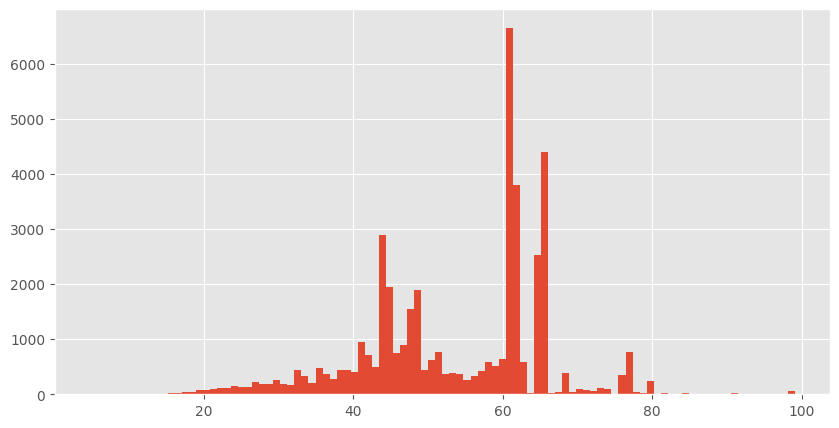

In [10]:
# How many null values are there per row?
# And how do these null values correlate with sepsis? First, let's look at the null values per row.
# Maybe there is a clear pattern, e.g. all rows with sepsis == 1 have a lot of null values or vice versa.

# Count number of null values per row
null_counts = variables.isnull().sum(axis=1)
# Divide by number of columns to get percentage of null values per row
null_counts = (null_counts / variables.shape[1]) * 100

# Plot histogram of null values per row
null_counts.hist(bins=100, figsize=(10, 5))

# Add null_counts as new column to df
variables["null_counts"] = null_counts

# Print average percentage of null values per row, split by sepsis
# (Should roughly equal 33% for sepsis==1 and 30% for sepsis==0)
print("Average percentage of null values per row where sepsis == 1: ", variables[variables["sepsis"] == 1]["null_counts"].mean())
print("Average percentage of null values per row where sepsis == 0: ", variables[variables["sepsis"] == 0]["null_counts"].mean())

# Drop null_counts column again
if "null_counts" in variables.columns:
    variables.drop("null_counts", axis=1, inplace=True)

# Coarse grained view is inconclusive, let's look at a finer grained view...

<Axes: title={'center': 'Percentage of null values per variable (Sepsis - Not Sepsis)'}>

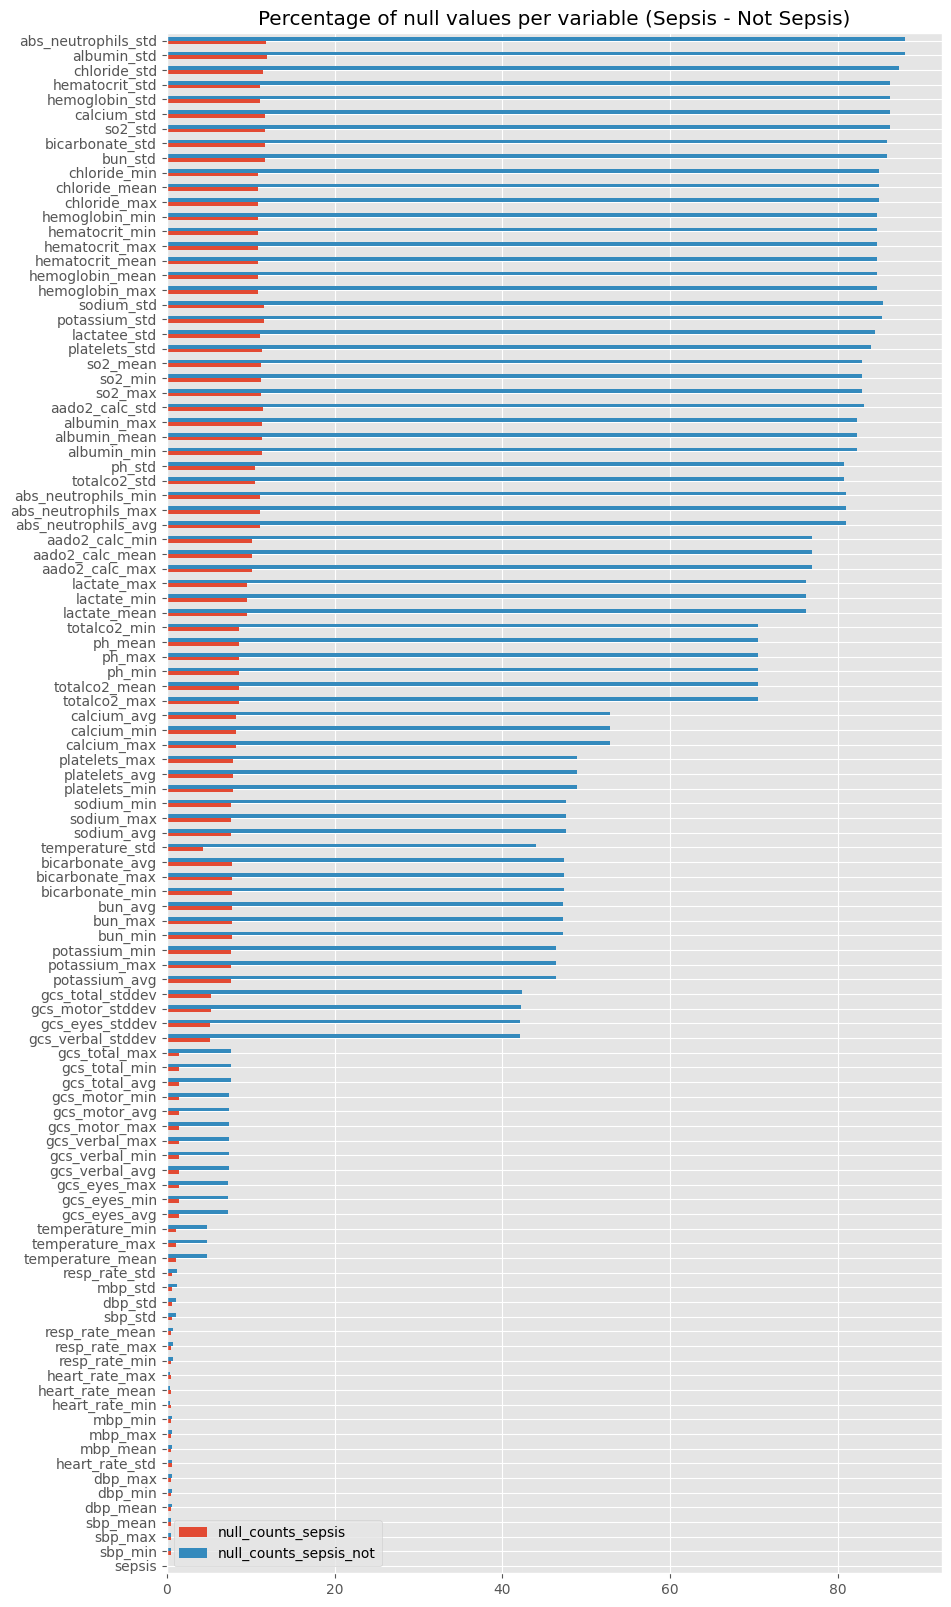

In [11]:
# What about the distribution of null values per column, i.e. the distribution of null values for each variable?
# Maybe the average number of null values per row is roughly the same, but the distribution of null values per column could be different.
# This could mean that the model would still be able to learn a shortcut, e.g. "if variable x is null, then sepsis == 1".

# Count number of null values per column, i.e. per variable
null_counts_sepsis = variables[variables["sepsis"] == 1].isnull().sum(axis=0).to_frame(name="null_counts")
null_counts_sepsis_not = variables[variables["sepsis"] == 0].isnull().sum(axis=0).to_frame(name="null_counts")

# Divide by number of rows to get percentage of null values per column, i.e. per variable
# (We use the number of overall rows to obtain the percentage of null values per column, not the number of rows where sepsis == 1 or sepsis == 0)
null_counts_sepsis = (null_counts_sepsis / variables.shape[0]) * 100
null_counts_sepsis_not = (null_counts_sepsis_not / variables.shape[0]) * 100

# Join null_counts_sepsis and null_counts_sepsis_not to plot them in one plot
null_counts_sepsis = null_counts_sepsis.join(null_counts_sepsis_not, lsuffix="_sepsis", rsuffix="_sepsis_not")

# Plot bar chart of null values per column, sort by difference in null values
null_counts_sepsis["diff"] = abs(null_counts_sepsis["null_counts_sepsis"] - null_counts_sepsis["null_counts_sepsis_not"])

# Do not display difference in bar chart, but sort by difference
null_counts_sepsis.sort_values(by="diff", ascending=True).drop("diff", axis=1).plot.barh(figsize=(10, 20), title="Percentage of null values per variable (Sepsis - Not Sepsis)")

# Indeed, there are some variables where the difference in null values is quite large.
# For example, patients that develop a sepsis have a lot more null values for the variable "abs_neutrophils_avg" than patients that do not develop a sepsis.
# Let's try to calculate the correlation between the presence of a variable and the sepsis target.

<Axes: title={'center': 'Correlation of (presence encoded) variables with sepsis'}>

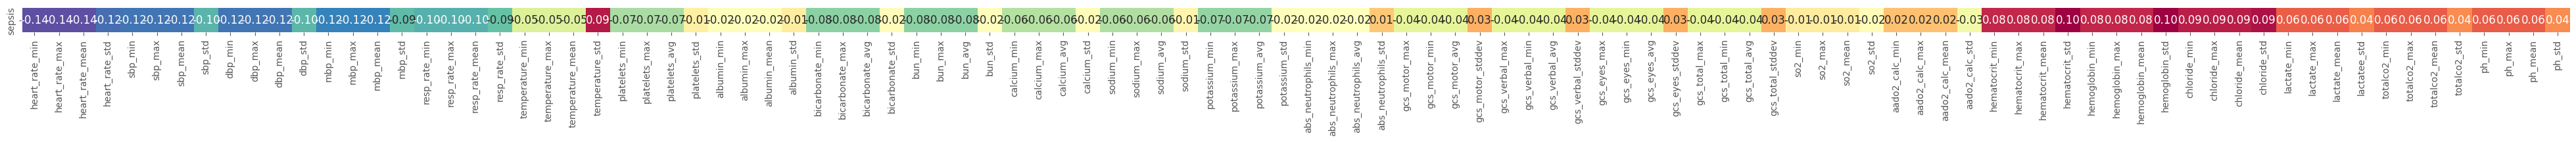

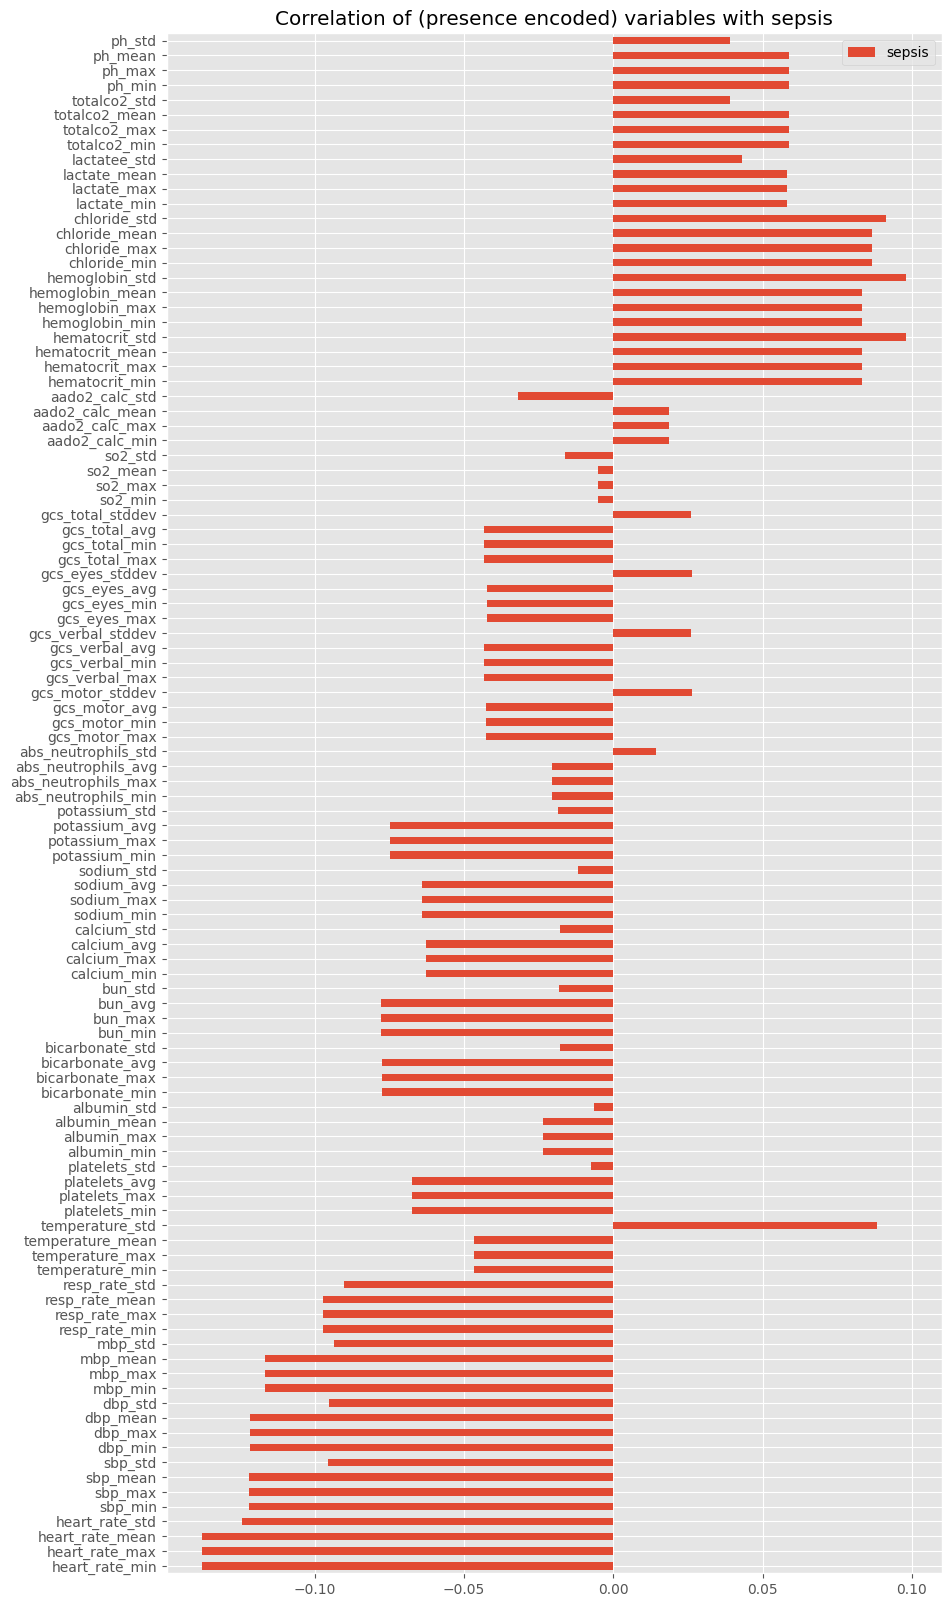

In [12]:
# To plot the correlation matrix, we need to replace the null values with some other value to encode the absence of a variable.
# Likewise, we need to replace all values != 0 with some other value to encode the presence of a variable.
# Let's use 0 for the absence of a variable and 1 for the presence of a variable.

# Split off the sepsis (target) column
sepsis = variables["sepsis"]

# Presence encode the feature set, i.e. replace all NaN values with 0 and all values != NaN with 1
present = variables.notna().astype(int)
present = present.replace(0, -1)
# Replace the sepsis column with the original
present["sepsis"] = sepsis

# Compute the correlation matrix
corr = present.corr(method="pearson")
# The correlation matrix is a bit hard to read, let's extract only the correlations with the sepsis target.
# Drop all columns except the sepsis column
corr = corr.drop([col for col in corr.columns if col != "sepsis"])
# Drop sepsis entry from that column
corr = corr.drop(["sepsis"], axis=1)

# Let's plot only the correlations with the sepsis target.
# Still as a heatmap, because it's easier to see the correlations.
plt.subplots(figsize=(50, 5))
sns.heatmap(corr, annot=True, annot_kws={"size": 12}, cbar=False, cmap="Spectral_r", fmt=".2f", square=True)


# Let's plot the correlations with the sepsis target as a bar chart.
corr.T.plot.barh(figsize=(10, 20), title="Correlation of (presence encoded) variables with sepsis")

# This indicates that the simple presence of a variable is apparently a good indicator. This can be good or bad...
# It could mean that the model is able to learn a shortcut, e.g. "if variable x is present, then sepsis == 1".
# Or it could mean that the model is able to learn a causal relationship, e.g. some measurements are done less frequently for certain patients due to reasons we don't know.
# For example, maybe the variable "abs_neutrophils_avg" is only measured for patients that are already suspected to have a sepsis. (Although this is just a guess...)
# It is more likely that the model is able to learn a shortcut, because the correlations are quite high. (e.g. -0.63 for "temperature_std", 0.41 for "abs_neutrophils_avg")

# Note that negative correlations mean that the presence of a variable is negatively correlated with the sepsis target, i.e. the absence of a variable is positively correlated with the sepsis target.
# I.e. the absence of a variable is a good indicator for sepsis.
# Likewise, positive correlations mean that the presence of a variable is positively correlated with the sepsis target, i.e. the presence of a variable is a good indicator for sepsis.

In [14]:
# Based on the above, let's try to train a model simply using the presence of a variable as a feature.
# Let's use a gradient boosting classifier using the XGBoost library.

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import matthews_corrcoef

# Convert types to float64
present = present.astype("float64")
# Split into features and target
X, y = present.drop("sepsis", axis=1), present[["sepsis"]]

# Split into train and test set
# Use 20% of the data for testing, use a fixed random state to make results reproducible
# Use stratify=y to ensure that the train and test set have the same ratio of sepsis==1 and sepsis==0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Create regressor matrices
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.nan)

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 10],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.5, 0.7],
    "scale_pos_weight": [ratio, ratio * 2, ratio * 0.5]
}

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist")
# Use grid search to find the best hyperparameters, use 5-fold (stratified) cross validation, use MCC as scoring metric
# Use verbose=5 to display progress, use n_jobs=-1 to use all available CPU cores
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='matthews_corrcoef', verbose=5, n_jobs=10)
grid_search.fit(X_train, y_train)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(X_test)
# Calculate the Matthews correlation coefficient
print("MCC: ", matthews_corrcoef(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.5}
Best score:  0.1891513997536744
MCC:  0.16871597825584944


In [ ]:
# Let's take a look at the learned tree.
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(grid_search.best_estimator_, ax=ax, rankdir="LR")
plt.show()

In [ ]:
# XGBoost provides some built-in functions to plot feature importance
# We'll ignore those for now and use the shap library instead, anyway here's how to use the built-in functions:
# Gain: Improvement in accuracy resulting from a split according to this feature
# xgb.plot_importance(model, importance_type="gain", show_values=True, max_num_features=20)
# Weight: Number of times this feature occurs in the trees
# xgb.plot_importance(model, importance_type="weight", show_values=True, max_num_features=20)
# Cover: Number of times this feature occurs in the trees weighted by the number of training data points
# xgb.plot_importance(model, importance_type="cover", show_values=True, max_num_features=20)

# Let's look at the feature importance for the best estimator found by grid search (shap values)
import shap
# Initialize javascript visualization
shap.initjs()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Create a TreeExplainer object using the best estimator
model = grid_search.best_estimator_
explainer = shap.TreeExplainer(model)
# Calculate shap values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the shap values for the test set, only show the 20 most important features
shap.summary_plot(shap_values, X_test, max_display=20)
# Plot the shap values for the test set as a bar chart, only show the 20 most important features
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
# Some quick notes on interpretability:
# Color encodes the feature value, red means high feature value (aka 1, variable present), blue means low feature value (aka 0, variable absent)
# The x-axis encodes the impact on the model output, i.e. the prediction, left means negative impact, right means positive impact

In [ ]:
# Which of the 20 most important features are also in the top 20 features by correlation and the top 20 features by difference in null value percentages?
shap_values = explainer.shap_values(X_test)

# Zip shap values with their feature names
shap_values_ = zip(X_test.columns, np.abs(shap_values).mean(0))

# Get the names of the 20 most important features by shap values
top_20_by_shap = X_test.columns[np.argsort(np.abs(shap_values).mean(0))][-20:].values
# Get the names of the 20 most important features by correlation
top_20_by_corr = abs(corr).T["sepsis"].sort_values(ascending=False).head(20).index.values
# Get the percentage of null values for each feature, split by sepsis

top_20_by_diff = null_counts_sepsis.sort_values(by="diff", ascending=False).head(20).index.values

# Print set of features that are in all top 20 sets
print("Features in all top 20 sets: ", feature_set(top_20_by_shap).intersection(feature_set(top_20_by_corr)).intersection(feature_set(top_20_by_diff)))

# Features in both top 20 sets:  {'gcs_eyes_stddev', 'abs_neutrophils_max', 'gcs_total_stddev', 'abs_neutrophils_min', 'temperature_std'}

# top_by_shap = X_test.columns[np.argsort(np.abs(shap_values).mean(0))] # .values
# Use feature names as index, shap values as values
top_by_shap = pd.DataFrame(zip(X_test.columns, np.abs(shap_values).mean(0)))

# top_by_shap = pd.DataFrame(zip(X_test.columns[np.argsort(np.abs(shap_values).mean(0))], np.abs(shap_values).mean(0)))
print(top_by_shap.sort_values(by=1))
# Use column 0 as index, column 1 as values
top_by_shap = top_by_shap.set_index(0)[1].to_frame(name="shap")
top_by_corr = abs(corr).T["sepsis"].sort_values(ascending=False).to_frame(name="corr")
top_by_diff = null_counts_sepsis["diff"].sort_values(ascending=False).to_frame(name="diff") # .index.values
top_by_sepsis_null_count = null_counts_sepsis["null_counts_sepsis"].sort_values(ascending=False).to_frame(name="null_counts_sepsis")
top_by_sepsis_not_null_count = null_counts_sepsis["null_counts_sepsis_not"].sort_values(ascending=False).to_frame(name="null_counts_sepsis_not")

# Normalize shap values
top_by_shap = (top_by_shap - top_by_shap.min()) / (top_by_shap.max() - top_by_shap.min())
# Normalize correlation values
top_by_corr = (top_by_corr - top_by_corr.min()) / (top_by_corr.max() - top_by_corr.min())
# Normalize difference in null value percentages
top_by_diff = (top_by_diff - top_by_diff.min()) / (top_by_diff.max() - top_by_diff.min())
# Normalize difference in null value percentages
top_by_sepsis_null_count = (top_by_sepsis_null_count - top_by_sepsis_null_count.min()) / (top_by_sepsis_null_count.max() - top_by_sepsis_null_count.min())
# Normalize difference in null value percentages
top_by_sepsis_not_null_count = (top_by_sepsis_not_null_count - top_by_sepsis_not_null_count.min()) / (top_by_sepsis_not_null_count.max() - top_by_sepsis_not_null_count.min())

# Join all three dataframes and plot them as bar charts
top_features = top_by_shap.join(top_by_corr, lsuffix="_shap", rsuffix="_corr").join(top_by_diff["diff"], rsuffix="_diff").join(top_by_sepsis_null_count["null_counts_sepsis"], rsuffix="_null_counts_sepsis").join(top_by_sepsis_not_null_count["null_counts_sepsis_not"], rsuffix="_null_counts_sepsis_not")
# Plot bar chart, sort by shap values
top_features.sort_values(by="shap", ascending=True).plot.barh(figsize=(10, 30), title="Features by shap values, correlation and difference in null value percentages")

### Let's compare that to the model performance on the (not encoded) dataset.

In [ ]:
variables = sql_to_df("./sql/variables_filtered.sql")

# Drop stay_id and subject_id columns, since they are not needed for the analysis
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

In [ ]:
# Train XGBoost Model on unencoded data to test if the model performs better on unencoded data
# Would indicate that the model is able to learn more from the data than just the presence of a variable (which is hopefully the case)

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import matthews_corrcoef


# Convert types to float64
variables = variables.astype("float64")

# Replace null values with -1
variables = variables.fillna(-1)

# Split into features and target
X, y = variables.drop("sepsis", axis=1), variables[["sepsis"]]

# Split into train and test set
# Use 20% of the data for testing, use a fixed random state to make results reproducible
# Use stratify=y to ensure that the train and test set have the same ratio of sepsis==1 and sepsis==0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Create regressor matrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [5, 6, 10],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.5, 0.7],
}

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist")
# Use grid search to find the best hyperparameters, use 5-fold (stratified) cross validation, use MCC as scoring metric
# Use verbose=5 to display progress, use n_jobs=-1 to use all available CPU cores
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='matthews_corrcoef', verbose=5, n_jobs=10)
grid_search.fit(X_train, y_train)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Test the model on the test set
y_pred = grid_search.predict(X_test)
# Calculate the Matthews correlation coefficient
print("MCC: ", matthews_corrcoef(y_test, y_pred))

# MCC of 0.77 is laughably good using only the presence of a variable as a feature.
# Let's investigate the feature importance to see which variables are most important.

In [ ]:
# Let's look at the feature importance for the best estimator found by grid search (shap values)
import shap
# Initialize javascript visualization
shap.initjs()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Create a TreeExplainer object using the best estimator
model = grid_search.best_estimator_
explainer = shap.TreeExplainer(model)
# Calculate shap values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the shap values for the test set, only show the 20 most important features
shap.summary_plot(shap_values, X_test, max_display=20)
# Plot the shap values for the test set as a bar chart, only show the 20 most important features
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
# Some quick notes on interpretability:
# Color encodes the feature value, red means high feature value (aka 1, variable present), blue means low feature value (aka 0, variable absent)
# The x-axis encodes the impact on the model output, i.e. the prediction, left means negative impact, right means positive impact

### How many values factor into the aggregate?

In [ ]:
# How many values factor into the aggregation functions (min, max, avg, stddev)?
variable_counts = sql_to_df("./sql/variables_filtered_counts.sql")

# Drop stay_id and subject_id columns, since they are not needed for the analysis
if "stay_id" in variable_counts.columns and "subject_id" in variable_counts.columns:
    variable_counts.drop(["stay_id", "subject_id"], axis=1, inplace=True)

In [ ]:
# General statistics
variable_counts.describe().T

In [ ]:
# Split variable counts by sepsis target (sepsis == 1, sepsis == 0)
variable_counts_sepsis = variable_counts[variable_counts["sepsis"] == 1]
variable_counts_not_sepsis = variable_counts[variable_counts["sepsis"] == 0]

In [ ]:
# How many values factor into the aggregate (sepsis == 1)?
variable_counts_sepsis.describe().T

# We notice, that the number of measurements for each variable is lower for sepsis == 1 than for sepsis == 0.
# With respect to the number of temperature values measured, the difference explains the gap in null values between sepsis == 1 and sepsis == 0.
# As we use PostgreSQL's STDDEV function (wich is an alias for STDDEV_SAMP) the value for n smaller than 2 will result in a NULL value.
# This is due to the fact, that the sample standard deviation is undefined for n < 2. (https://stackoverflow.com/a/11214835/9969134)
# (divides by N - 1, which is 0 for n < 2)

# Wiki: https://en.wikipedia.org/wiki/Standard_deviation#Estimation

# NOTE: we could use the STDDEV_POP function instead, which is defined for n < 2. (divides by N, returns 0 for n = 0)
# TODO: does this fix the underlying problem?

In [ ]:
# How many values factor into the aggregate (sepsis == 0)?
variable_counts_not_sepsis.describe().T

# We notice, that the number of values that factor into the aggregate is generally higher for sepsis == 0 than for sepsis == 1.
# This is possibly due to the definition of the feature window, that is, the time window for patients without sepsis grows into their ICU stay whereas the time window for patients with sepsis grows into the past.
# The frequency of measurements taken in the ICU is higher than the frequency of measurements taken for patients not in the ICU.
# Therefore, the number of values that factor into the aggregate is generally higher for sepsis == 0 than for sepsis == 1.

#### Some notes on the number of measurements
- The number of measurements per feature varies greatly between septic / non-septic patients.
- The main reason for this is the feature window definition:
  - Septic patients: (Sepsis onset - 8 hours) - Sepsis onset (avg time to onset: Admission + ~7.1 hours)
  - Non-septic patients: ICU admission - ICU admission + 8 hours
- The frequency of recorded measurements is higher for ICU patients than for ward patients.
- Therefore, the number of measurements per feature is higher for non-septic patients as they are more likely to be in the ICU for the duration of their feature window.